In [53]:
'''
[Start Model Initialization (__init__ method)]
            |
            V
1️⃣ Define Convolution Layers:
    - conv1: Conv2d(1, 32, 5)
    - conv2: Conv2d(32, 64, 5)
    - conv3: Conv2d(64, 128, 5)
(Comment: These layers extract features from images)

            |
            V
2️⃣ Set self._to_linear = None
(Comment: Placeholder to store flattened size later)

            |
            V
3️⃣ Create Dummy Input Image:
    x = torch.randn(1, 1, 50, 50)
(Comment: This simulates a random grayscale image of size 50x50.
Purpose: To auto-calculate the flattened size after conv layers.)

            |
            V
4️⃣ Pass Dummy Input Through convs(x):
(Comment: This step will apply convolutions, activations & pooling)

            |
            V
Inside convs(x):
 ├── Apply conv1 → ReLU → Max Pool (2x2)
 ├── Apply conv2 → ReLU → Max Pool (2x2)
 ├── Apply conv3 → ReLU → Max Pool (2x2)
 └── Print shape of output feature maps (for debug)

(Comment: Here the image gets smaller after each pooling step.
Feature maps are extracted and dimensions reduced.)

            |
            V
If self._to_linear is None:
 └── Set self._to_linear = number of features in output tensor
(Comment: This step auto-detects the required input size for the fc layer.)

            |
            V
Return processed tensor back to __init__

            |
            V
5️⃣ Now, we know _to_linear.
Define Fully Connected Layers:
 ├── fc1 = nn.Linear(self._to_linear, 512)
 └── fc2 = nn.Linear(512, 2)
(Comment: Now we can safely define linear layers because we know the flattened size.)

            |
            V
[Model Initialization Complete ✅]




[Start Forward Pass: forward(x)]
            |
            V
1️⃣ Pass Input x Through convs(x):
 └── Convolutions → ReLU → Pooling (Same as dummy pass but now with real data)

            |
            V
2️⃣ Flatten Output Tensor:
 └── x.view(-1, self._to_linear)
(Comment: Converts 3D feature maps to 1D vector for fully connected layers.)

            |
            V
3️⃣ Pass Through Fully Connected Layers:
 ├── fc1 → ReLU Activation
 └── fc2 (Output Layer: 2 logits for classification)
(Comment: This is where the model makes predictions.)

            |
            V
[Output: Final Prediction (Logits)]

'''

'\n[Start Model Initialization (__init__ method)]\n            |\n            V\n1️⃣ Define Convolution Layers:\n    - conv1: Conv2d(1, 32, 5)\n    - conv2: Conv2d(32, 64, 5)\n    - conv3: Conv2d(64, 128, 5)\n(Comment: These layers extract features from images)\n\n            |\n            V\n2️⃣ Set self._to_linear = None\n(Comment: Placeholder to store flattened size later)\n\n            |\n            V\n3️⃣ Create Dummy Input Image:\n    x = torch.randn(1, 1, 50, 50)\n(Comment: This simulates a random grayscale image of size 50x50.\nPurpose: To auto-calculate the flattened size after conv layers.)\n\n            |\n            V\n4️⃣ Pass Dummy Input Through convs(x):\n(Comment: This step will apply convolutions, activations & pooling)\n\n            |\n            V\nInside convs(x):\n ├── Apply conv1 → ReLU → Max Pool (2x2)\n ├── Apply conv2 → ReLU → Max Pool (2x2)\n ├── Apply conv3 → ReLU → Max Pool (2x2)\n └── Print shape of output feature maps (for debug)\n\n(Comment: Here t

In [54]:
import os
import cv2
import numpy as np
from langsmith import expect
from tqdm import tqdm

In [55]:
class DogsvsCats:
    def __init__(self):
        self.Img_size = 50
        self.CATS = "PetImages/Cat"
        self.DOGS = "PetImages/Dog"
        self.LABELS = {self.CATS: 0, self.DOGS: 1}
        self.training_data = []
        self.catcount = 0
        self.dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print("Processing:", label)
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.Img_size, self.Img_size))
                    self.training_data.append(
                        [np.array(img), np.eye(2)[self.LABELS[label]]]
                    )

                    if label == self.CATS:
                        self.catcount += 1
                    elif label == self.DOGS:
                        self.dogcount += 1
                except Exception as e:
                    pass
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", np.array(self.training_data, dtype=object))
        print("Cats: ", self.catcount)
        print("Dogs: ", self.dogcount)


if __name__ == "__main__":
    dogsvscats = DogsvsCats()
    dogsvscats.make_training_data()

Processing: PetImages/Cat


 11%|█         | 1356/12501 [00:14<01:58, 94.43it/s] 


KeyboardInterrupt: 

In [57]:
np.eye(2)[0]

array([1., 0.])

In [58]:
training_data = np.load("training_data.npy",allow_pickle=True)

In [59]:
print(len(training_data))

24946


In [60]:
training_data[3]

array([array([[ 80,  80,  83, ..., 101,  99,  99],
              [ 80,  84,  84, ..., 101, 101,  99],
              [ 82,  85,  87, ..., 101, 101, 100],
              ...,
              [ 96,  82,  36, ...,  97,  97,  99],
              [101,  77,  41, ...,  97,  99,  99],
              [107,  74,  45, ..., 118, 101,  97]], dtype=uint8),
       array([0., 1.])], dtype=object)

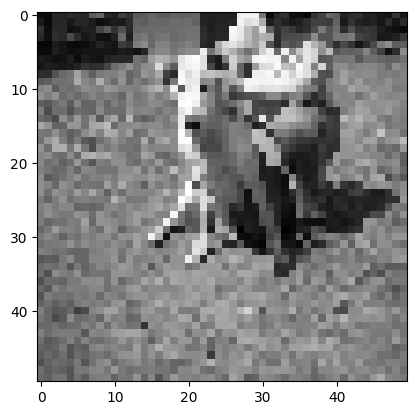

In [61]:
import matplotlib.pyplot as plt

plt.imshow(training_data[2][0],cmap="gray")

In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        self._to_linear = None

        # Dummy forward pass to auto-compute _to_linear
        x = torch.randn(1, 1, 50, 50)  # batch_size=1, grayscale=1, 50x50
        self.convs(x)

        # ✅ Now we know _to_linear, we can safely initialize fc1:
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        print(f"Shape after conv layers: {x[0].shape}")
        if self._to_linear is None:
            self._to_linear = x[0].numel()  # Number of features after conv layers
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate network
net = Net()


Shape after conv layers: torch.Size([128, 2, 2])


[Start Model Initialization (__init__ method)]
            |
            V
1️⃣ Define Convolution Layers:
    - conv1: Conv2d(1, 32, 5)
    - conv2: Conv2d(32, 64, 5)
    - conv3: Conv2d(64, 128, 5)
(Comment: These layers extract features from images)

            |
            V
2️⃣ Set self._to_linear = None
(Comment: Placeholder to store flattened size later)

            |
            V
3️⃣ Create Dummy Input Image:
    x = torch.randn(1, 1, 50, 50)
(Comment: This simulates a random grayscale image of size 50x50.
Purpose: To auto-calculate the flattened size after conv layers.)

            |
            V
4️⃣ Pass Dummy Input Through convs(x):
(Comment: This step will apply convolutions, activations & pooling)

            |
            V
Inside convs(x):
 ├── Apply conv1 → ReLU → Max Pool (2x2)
 ├── Apply conv2 → ReLU → Max Pool (2x2)
 ├── Apply conv3 → ReLU → Max Pool (2x2)
 └── Print shape of output feature maps (for debug)

(Comment: Here the image gets smaller after each pooling step.
Feature maps are extracted and dimensions reduced.)

            |
            V
If self._to_linear is None:
 └── Set self._to_linear = number of features in output tensor
(Comment: This step auto-detects the required input size for the fc layer.)

            |
            V
Return processed tensor back to __init__

            |
            V
5️⃣ Now, we know _to_linear.
Define Fully Connected Layers:
 ├── fc1 = nn.Linear(self._to_linear, 512)
 └── fc2 = nn.Linear(512, 2)
(Comment: Now we can safely define linear layers because we know the flattened size.)

            |
            V
[Model Initialization Complete ✅]




[Start Forward Pass: forward(x)]
            |
            V
1️⃣ Pass Input x Through convs(x):
 └── Convolutions → ReLU → Pooling (Same as dummy pass but now with real data)

            |
            V
2️⃣ Flatten Output Tensor:
 └── x.view(-1, self._to_linear)
(Comment: Converts 3D feature maps to 1D vector for fully connected layers.)

            |
            V
3️⃣ Pass Through Fully Connected Layers:
 ├── fc1 → ReLU Activation
 └── fc2 (Output Layer: 2 logits for classification)
(Comment: This is where the model makes predictions.)

            |
            V
[Output: Final Prediction (Logits)]


In [64]:
import torch.optim as optim
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

X=torch.Tensor([i[0] for i in training_data]).view(-1,50*50)
X=X/255.0
y=torch.Tensor([i[1] for i in training_data])

VAL_PCT=0.1
val_size=int(len(X)*VAL_PCT)
print(val_size)


2494


In [65]:
train_X=X[:-val_size]
train_y=y[:-val_size]

test_X=X[-val_size:]
test_y=y[-val_size:]

print(len(train_X))
print(len(test_X))



22452
2494


In [68]:
BATCH_SIZE=100
EPOCHS=1

for epoch in range(EPOCHS):
    for i in range(0,len(train_X),BATCH_SIZE):
        #print(i,i+BATCH_SIZE)
        batch_x=train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y=train_y[i:i+BATCH_SIZE]
        optimizer.zero_grad()
        outputs = net(batch_x)
        loss = loss_fn(outputs, batch_y)
        loss.backward()
        optimizer.step()
print(loss)

Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv lay

In [69]:
correct=0
total=0
with torch.no_grad():
    for i in range(len(test_X)):
        real_class=torch.argmax(y[i])
        net_output=net(test_X[i].view(-1,1,50,50))[0]
        predicted_class=torch.argmax(net_output)
        if predicted_class == real_class:
            correct += 1
        total += 1
print(correct/total)

Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv layers: torch.Size([128, 2, 2])
Shape after conv lay